In [1]:
pip install pyspark py4j

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from scipy.stats import ttest_ind
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,mean_absolute_error, mean_squared_error, r2_score
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.svm import SVC,OneClassSVM,SVR
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor

In [5]:
# Initiating a PySpark session
spark = SparkSession.builder.appName("Melbourne Housing Analysis").getOrCreate()
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
# Read CSV files
df = spark.read.csv('melb_data.csv', header=True, inferSchema=True)
df.show()

+----------+-------------------+-----+----+---------+------+-------+----------+--------+--------+--------+--------+---+--------+------------+---------+-----------+---------+----------+--------------------+-------------+
|    Suburb|            Address|Rooms|Type|    Price|Method|SellerG|      Date|Distance|Postcode|Bedroom2|Bathroom|Car|Landsize|BuildingArea|YearBuilt|CouncilArea|Lattitude|Longtitude|          Regionname|Propertycount|
+----------+-------------------+-----+----+---------+------+-------+----------+--------+--------+--------+--------+---+--------+------------+---------+-----------+---------+----------+--------------------+-------------+
|Abbotsford|       85 Turner St|    2|   h|1480000.0|     S| Biggin| 3/12/2016|     2.5|  3067.0|     2.0|     1.0|1.0|   202.0|        null|     null|      Yarra| -37.7996|  144.9984|Northern Metropol...|       4019.0|
|Abbotsford|    25 Bloomburg St|    2|   h|1035000.0|     S| Biggin| 4/02/2016|     2.5|  3067.0|     2.0|     1.0|0.0| 

In [ ]:
# Loading the dataset
df_pd = pd.read_csv("/content/melb_data.csv")
# 1. Handle missing values
for col in df_pd.columns:
    if df_pd[col].dtype == 'object':
        df_pd[col].fillna(df_pd[col].mode()[0], inplace=True)
    else:
        df_pd[col].fillna(df_pd[col].median(), inplace=True)
'''
# 2. Find and handle outliers
# Use IQR to determine upper and lower bounds for outliers
Q1 = df_pd.quantile(0.25)
Q3 = df_pd.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# Replace outliers with the lower bound
for col in df_pd.columns:
    if df_pd[col].dtype != 'object':
        df_pd[col] = df_pd[col].apply(lambda x: upper_bound[col] if x > upper_bound[col] else x)
        df_pd[col] = df_pd[col].apply(lambda x: lower_bound[col] if x < lower_bound[col] else x)

'''
df_pd.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,126.0,1970.0,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,2.0,1.0,94.0,126.0,1970.0,Yarra,-37.7969,144.9969,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.8072,144.9941,Northern Metropolitan,4019.0


When I realized something was wrong with the data, I abandoned the approach of finding and handling outliers and replacing them with upper and lower bounds

In [ ]:
df = spark.createDataFrame(df_pd)
df = df.withColumn("Date", to_date(df["Date"], "dd/MM/yyyy"))
# Extract the year from the date
df = df.withColumn("Year", year(df["Date"]))
df = df.withColumn("Month", month(df["Date"]))
df = df.withColumn("Day", dayofmonth(df["Date"]))
# Calculate the average house price for each year
avg_price_per_year = df.groupBy("Year").agg(avg("Price").alias("Average Price"))
# Calculate the average price each region
avg_price_per_region = df.groupBy("Regionname").agg(avg("Price").alias("Average Price"))
median_price = df.approxQuantile('Price', [0.5], 0)[0]
df = df.withColumn('PriceCategory', when(df['Price'] > median_price, 'High').otherwise('Low'))
# The street name is extracted from the address using the split function
df = df.withColumn('StreetName', split(df['Address'], ' ')[1])
df.show()

+----------+-------------------+-----+----+---------+------+-------+----------+--------+--------+--------+--------+---+--------+------------+---------+-----------+---------+----------+--------------------+-------------+----+-----+---+-------------+----------+
|    Suburb|            Address|Rooms|Type|    Price|Method|SellerG|      Date|Distance|Postcode|Bedroom2|Bathroom|Car|Landsize|BuildingArea|YearBuilt|CouncilArea|Lattitude|Longtitude|          Regionname|Propertycount|Year|Month|Day|PriceCategory|StreetName|
+----------+-------------------+-----+----+---------+------+-------+----------+--------+--------+--------+--------+---+--------+------------+---------+-----------+---------+----------+--------------------+-------------+----+-----+---+-------------+----------+
|Abbotsford|       85 Turner St|    2|   h|1480000.0|     S| Biggin|2016-12-03|     2.5|  3067.0|     2.0|     1.0|1.0|   202.0|       126.0|   1970.0|      Yarra| -37.7996|  144.9984|Northern Metropol...|       4019.0|2

In [ ]:
df_sele = df.select('Address','Rooms','Type','Price','Date','Year','Month','Day','PriceCategory','StreetName')
df_sele.show()

+-------------------+-----+----+---------+----------+----+-----+---+-------------+----------+
|            Address|Rooms|Type|    Price|      Date|Year|Month|Day|PriceCategory|StreetName|
+-------------------+-----+----+---------+----------+----+-----+---+-------------+----------+
|       85 Turner St|    2|   h|1480000.0|2016-12-03|2016|   12|  3|         High|    Turner|
|    25 Bloomburg St|    2|   h|1035000.0|2016-02-04|2016|    2|  4|         High| Bloomburg|
|       5 Charles St|    3|   h|1465000.0|2017-03-04|2017|    3|  4|         High|   Charles|
|   40 Federation La|    3|   h| 850000.0|2017-03-04|2017|    3|  4|          Low|Federation|
|        55a Park St|    4|   h|1600000.0|2016-06-04|2016|    6|  4|         High|      Park|
|     129 Charles St|    2|   h| 941000.0|2016-05-07|2016|    5|  7|         High|   Charles|
|       124 Yarra St|    3|   h|1876000.0|2016-05-07|2016|    5|  7|         High|     Yarra|
|      98 Charles St|    2|   h|1636000.0|2016-10-08|2016|  

In [ ]:
df_pd_sele=df_sele.toPandas()
df_pd_sele

,Address,Rooms,Type,Price,Date,Year,Month,Day,PriceCategory,StreetName
0,85 Turner St,2,h,1480000.0,2016-12-03,2016,12,3,High,Turner
1,25 Bloomburg St,2,h,1035000.0,2016-02-04,2016,2,4,High,Bloomburg
2,5 Charles St,3,h,1465000.0,2017-03-04,2017,3,4,High,Charles
3,40 Federation La,3,h,850000.0,2017-03-04,2017,3,4,Low,Federation
4,55a Park St,4,h,1600000.0,2016-06-04,2016,6,4,High,Park
...,...,...,...,...,...,...,...,...,...,...
13575,12 Strada Cr,4,h,1245000.0,2017-08-26,2017,8,26,High,Strada
13576,77 Merrett Dr,3,h,1031000.0,2017-08-26,2017,8,26,High,Merrett
13577,83 Power St,3,h,1170000.0,2017-08-26,2017,8,26,High,Power
13578,96 Verdon St,4,h,2500000.0,2017-08-26,2017,8,26,High,Verdon


In [ ]:
df_pd.to_csv("melb_data_clean.csv", index=False)
# Descriptive statistics for numeric columns
numeric_columns = ['Rooms', 'Price', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'Propertycount']
descriptive_stats = df_pd[numeric_columns].describe()
descriptive_stats

,Rooms,Price,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Propertycount
count,13580.000000,1.358000e+04,13580.000000,13580.000000,13580.000000,13580.000000,13580.000000,13580.000000,13580.000000,13580.000000
mean,2.937997,1.075684e+06,10.137776,2.914728,1.534242,1.611856,558.416127,139.633972,1966.788218,7454.417378
std,0.955748,6.393107e+05,5.868725,0.965921,0.691712,0.960793,3990.669241,392.217403,29.088642,4378.581772
min,1.000000,8.500000e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1196.000000,249.000000
25%,2.000000,6.500000e+05,6.100000,2.000000,1.000000,1.000000,177.000000,122.000000,1960.000000,4380.000000
50%,3.000000,9.030000e+05,9.200000,3.000000,1.000000,2.000000,440.000000,126.000000,1970.000000,6555.000000
75%,3.000000,1.330000e+06,13.000000,3.000000,2.000000,2.000000,651.000000,129.940000,1975.000000,10331.000000
max,10.000000,9.000000e+06,48.100000,20.000000,8.000000,10.000000,433014.000000,44515.000000,2018.000000,21650.000000


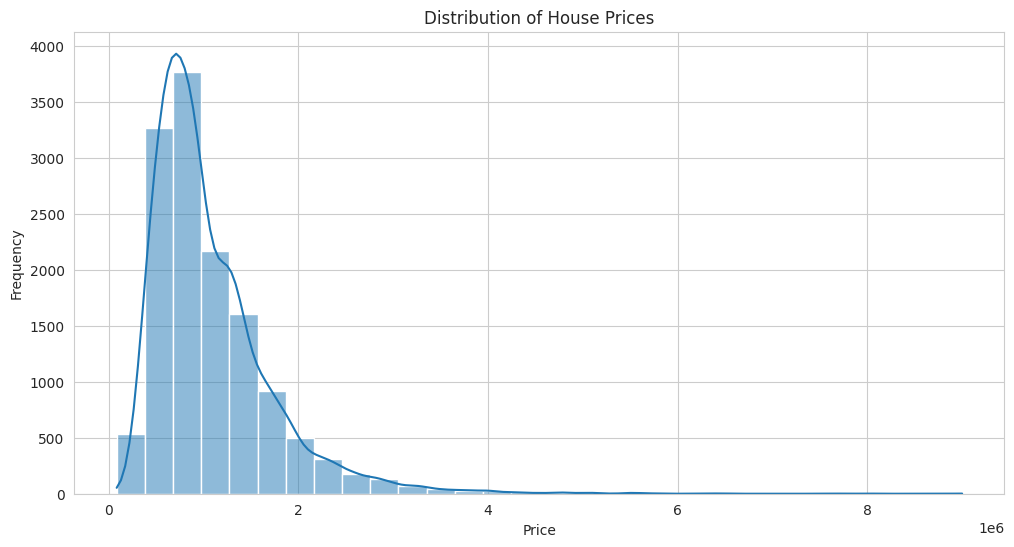

In [ ]:
sns.set_style("whitegrid")
#Price distribution map
plt.figure(figsize=(12, 6))
sns.histplot(df_pd['Price'], bins=30, kde=True)
plt.title('Distribution of House Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

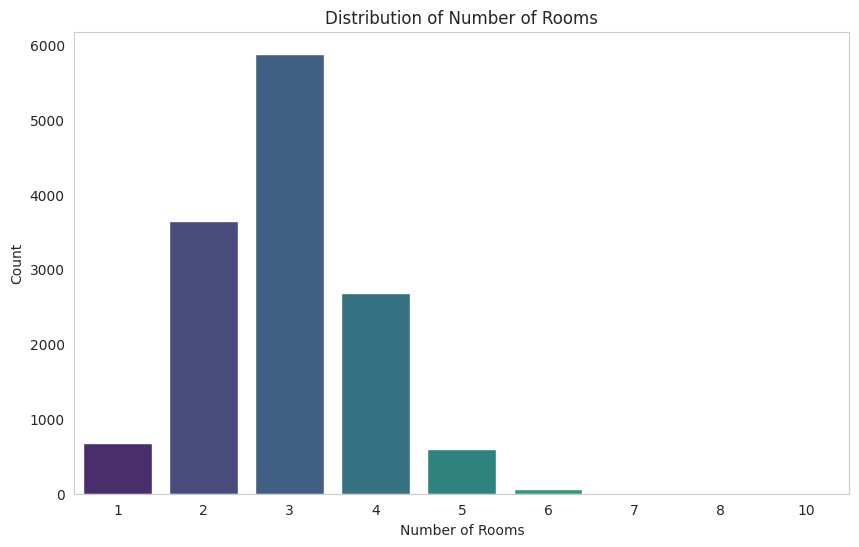

In [ ]:
# Visualize the distribution of rooms
plt.figure(figsize=(10, 6))
sns.countplot(data=df_pd, x='Rooms', palette='viridis')
plt.title('Distribution of Number of Rooms')
plt.xlabel('Number of Rooms')
plt.ylabel('Count')
plt.grid(axis='y')
plt.show()

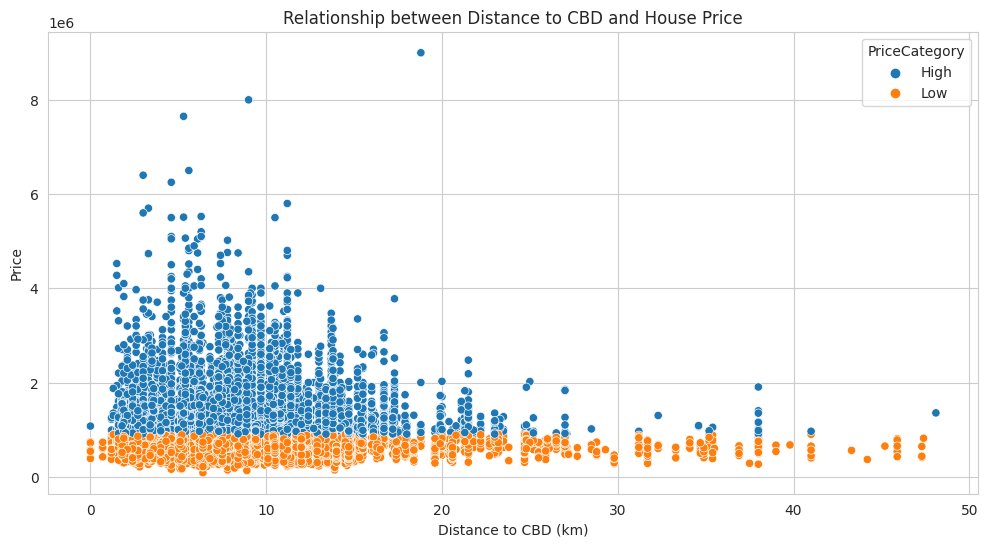

In [ ]:
# Prices in relation to the distance
# Create PriceCategory column
median_price = df_pd["Price"].median()
# Use the median price can be divided into two categories: 'Low' and 'High'
df_pd["PriceCategory"] = df_pd["Price"].apply(lambda x: 'High' if x > median_price else 'Low')
plt.figure(figsize=(12, 6))
sns.scatterplot(x=df_pd['Distance'], y=df_pd['Price'], hue=df_pd['PriceCategory'])
plt.title('Relationship between Distance to CBD and House Price')
plt.xlabel('Distance to CBD (km)')
plt.ylabel('Price')
plt.show()

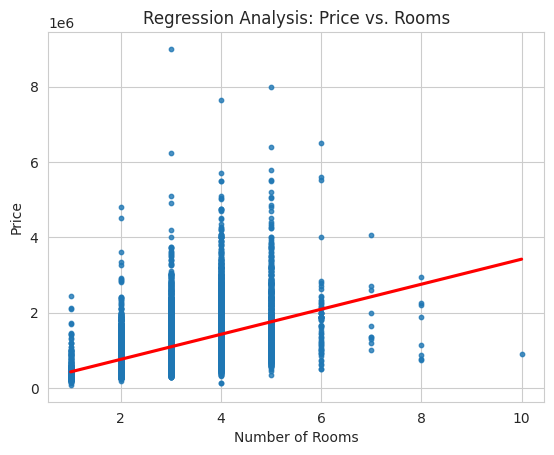

In [ ]:
# Scatter plot with regression line
sns.regplot(x=df_pd['Rooms'], y=df_pd['Price'], scatter_kws={"s": 10}, line_kws={"color": "red"}, ci=None)
plt.title('Regression Analysis: Price vs. Rooms')
plt.xlabel('Number of Rooms')
plt.ylabel('Price')
plt.show()

<ipython-input-17-8fff67a3fddd>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_pd.corr()


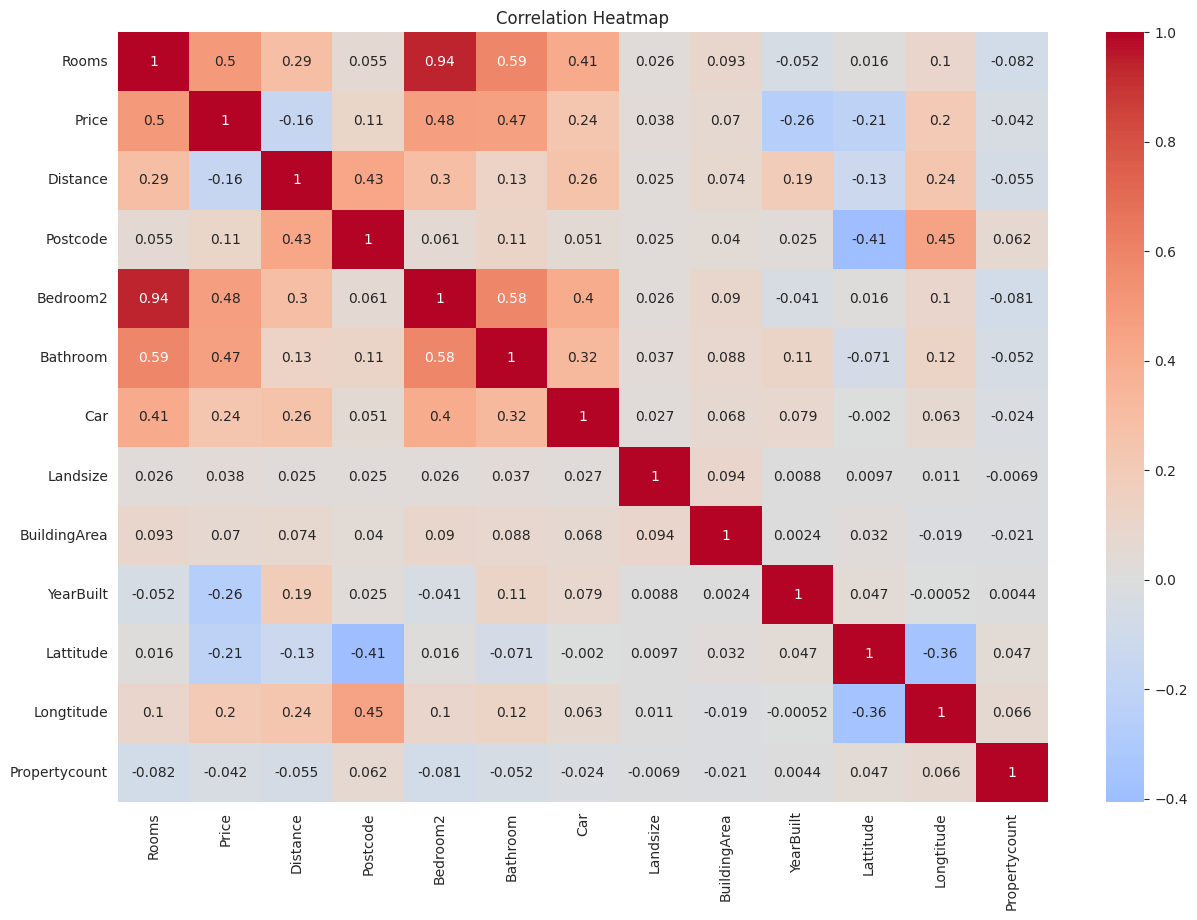

In [ ]:
# Calculate correlations without toPandas
corr_matrix = df_pd.corr()
# Plot the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
# Splitting data based on number of rooms
median_price = df_pd["Price"].median()
high_price_df = df_pd[df_pd["Price"] > median_price]
low_price_df = df_pd[df_pd["Price"] <= median_price]
# t-test
t_stat, p_value = ttest_ind(high_price_df["BuildingArea"].dropna(), low_price_df["BuildingArea"].dropna())
t_stat, p_value

(6.626375445762601, 3.570044207696455e-11)

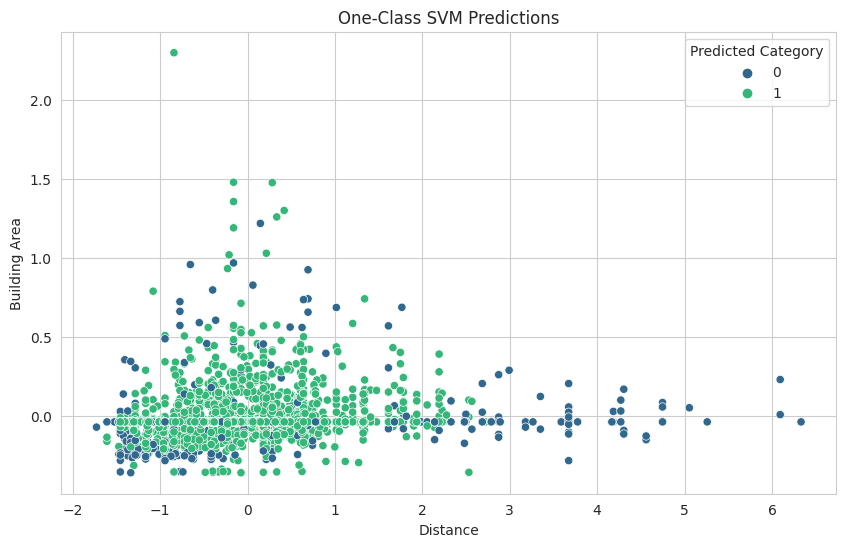

In [ ]:
# Select features and target variables
features = ['Rooms', 'Distance', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt']
target = 'Price'
X = df_pd[features]
y = df_pd[target]
# We will use houses with prices above the median as normal data for training
median_price = df_pd["Price"].median()
X_train = X[df_pd["Price"] > median_price]
# Standardized data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Divide the data set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
# Only the high price property data is used to train the One-Class SVM
median_price = df_pd['Price'].median()
X_train_high = X_train[y_train > median_price]
# Training a One-Class SVM
one_class_svm = OneClassSVM(kernel='rbf', nu=0.1, gamma=0.01)
one_class_svm.fit(X_train_high)
# The classifier is used to make predictions for the entire dataset
y_pred = one_class_svm.predict(X_test)
# The -1 is converted to 0 because the One-Class SVM returns 1 for normal data and -1 for abnormal data
y_pred = [1 if val == 1 else 0 for val in y_pred]
# Evaluating model performance
df_test = pd.DataFrame(X_test, columns=features)
df_test['Predicted'] = y_pred
# visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_test['Distance'], y=df_test['BuildingArea'], hue=df_test['Predicted'], palette='viridis')
plt.title('One-Class SVM Predictions')
plt.xlabel('Distance')
plt.ylabel('Building Area')
plt.legend(title='Predicted Category')
plt.show()

<ipython-input-37-a477da0c3cda>:26: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3, color='red',label='Perfect Prediction')


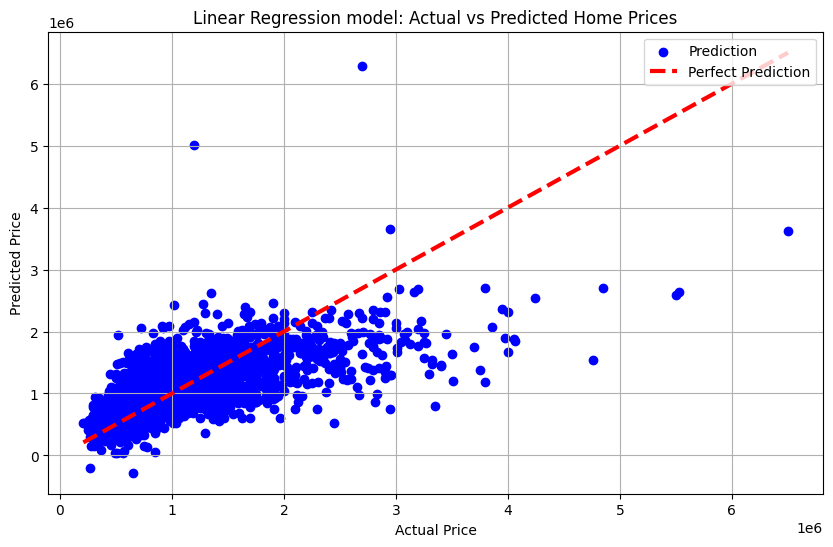

(328324.1352786986, 473620.26482060016, 0.4352761038881423)

In [ ]:
# Define features and target variable
features = ['Rooms', 'Distance', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt']
target = 'Price'

X = df_pd[features]
y = df_pd[target]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit the Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict the target variable
y_pred = lr_model.predict(X_test)

# Calculate the evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue',label='Prediction')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3, color='red',label='Perfect Prediction')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Linear Regression model: Actual vs Predicted Home Prices')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

mae, rmse, r2

<ipython-input-38-bb0756334c19>:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4, color='red', label='Perfect Prediction')


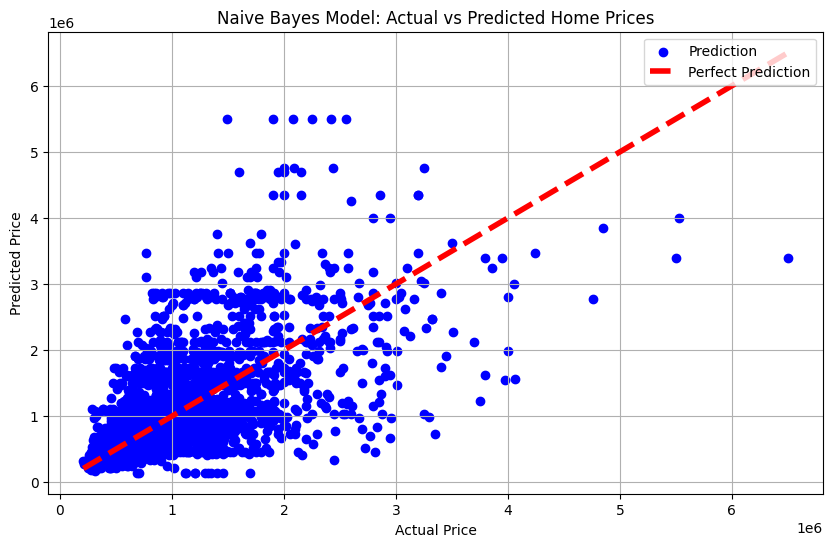

(436179.6638438881, 639083.6470698235, -0.028231779399698675)

In [ ]:
# Initialize and train the Naive Bayes model
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# Make predictions
y_pred = nb_model.predict(X_test)

# Calculate MAE, RMSE, and R2
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', label='Prediction')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4, color='red', label='Perfect Prediction')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Naive Bayes Model: Actual vs Predicted Home Prices')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

mae, rmse, r2

<ipython-input-39-d0642fa3ceaf>:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4, color='red', label='Perfect Prediction')


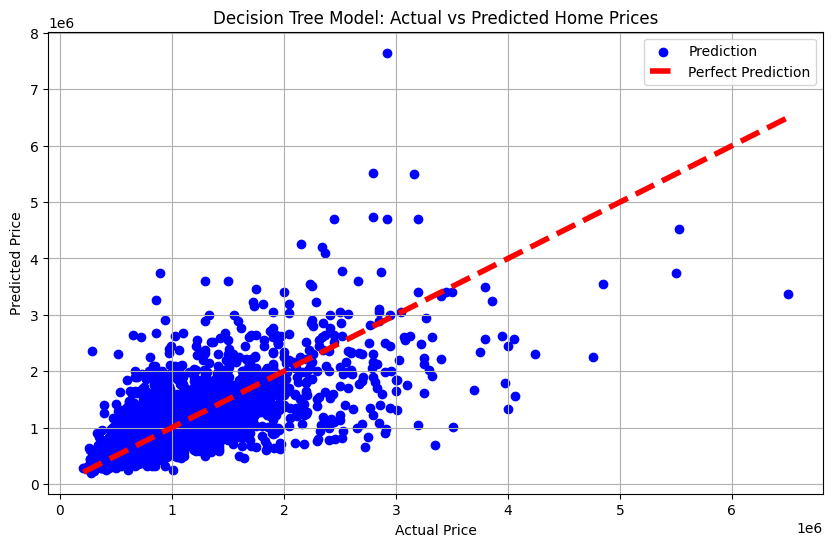

(321972.29962421395, 500704.9965970114, 0.3688400063064238)

In [ ]:
# Train Decision Tree model
decision_tree_model = DecisionTreeRegressor(random_state=42)
decision_tree_model.fit(X_train, y_train)

# Prediction
y_pred = decision_tree_model.predict(X_test)

# Evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Generate plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', label='Prediction')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4, color='red', label='Perfect Prediction')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Decision Tree Model: Actual vs Predicted Home Prices')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

mae, rmse, r2

<ipython-input-40-ccb0f5805b0c>:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2,color='red', label='Perfect Prediction')


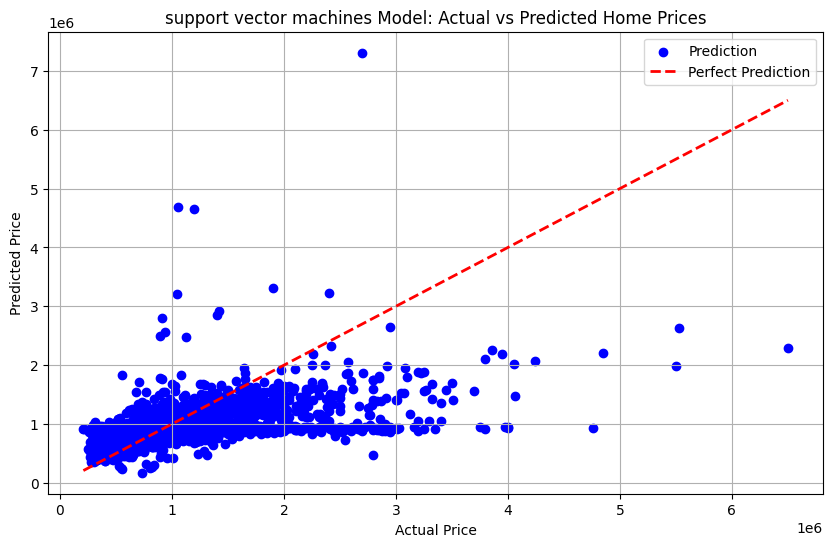

(363852.7282870614, 561660.7462375291, 0.20581120057214608)

In [ ]:
# Regression prediction was performed using support vector machines
svm_regressor = SVR(kernel='linear', C=1)
svm_regressor.fit(X_train, y_train)
y_pred = svm_regressor.predict(X_test)

# Evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Generate plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, c='blue', label='Prediction')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2,color='red', label='Perfect Prediction')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('support vector machines Model: Actual vs Predicted Home Prices')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

mae, rmse, r2

<ipython-input-33-6297baff287d>:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red', label='Perfect Prediction')


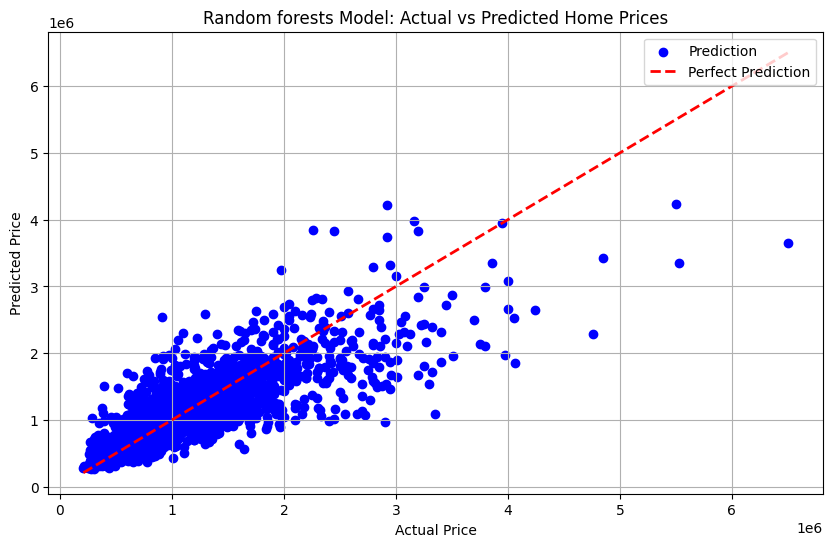

(238456.60404512746, 365656.8412246699, 0.6633930962600172)

In [ ]:
# Initialize the Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model
rf_model.fit(X_train, y_train)

# Predict the target for the testing set
y_pred = rf_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Plotting the actual vs predicted prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', label='Prediction')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red', label='Perfect Prediction')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Random forests Model: Actual vs Predicted Home Prices')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

mae, rmse, r2

In [ ]:
# Handling missing values
df_pd = df_pd.dropna()
# Creating binary target based on median of Price
median_price = df_pd['Price'].median()
df_pd['PriceCategory'] = ['High' if price > median_price else 'Low' for price in df_pd['Price']]

# Encoding categorical columns
label_encoders = {}
categorical_columns = df_pd.select_dtypes(include=['object']).columns.tolist()

for col in categorical_columns:
    le = LabelEncoder()
    df_pd[col] = le.fit_transform(df_pd[col])
    label_encoders[col] = le

# Splitting data into train and test sets
X = df_pd.drop(columns=['Price', 'PriceCategory'])
y = df_pd['PriceCategory']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Results dictionary to store performance of each classifier
results = {}

# Define classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=10000),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'Support Vector Machine': SVC(),
    'Random Forest': RandomForestClassifier()
}

# Training and evaluating models
for name, clf in classifiers.items():
    # Train
    clf.fit(X_train, y_train)

    # Predict
    y_pred = clf.predict(X_test)

    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    # Store results
    results[name] = {
        'Accuracy': accuracy,
        'Classification Report': report,
        'Model': clf
    }
results['Logistic Regression']['Accuracy'], results['Logistic Regression']['Classification Report']


(0.8230240549828178,
 '              precision    recall  f1-score   support\n\n           0       0.82      0.83      0.82      2042\n           1       0.82      0.82      0.82      2032\n\n    accuracy                           0.82      4074\n   macro avg       0.82      0.82      0.82      4074\nweighted avg       0.82      0.82      0.82      4074\n')

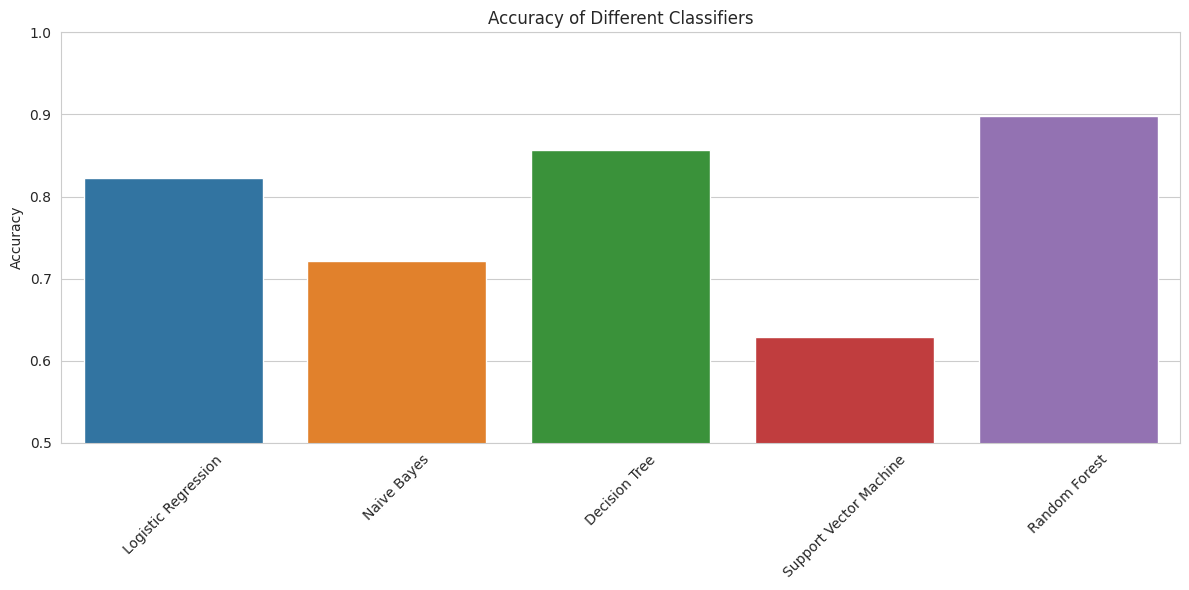

In [ ]:
# Extracting accuracy scores for visualization
accuracies = {name: res['Accuracy'] for name, res in results.items()}
# Visualizing accuracies
plt.figure(figsize=(12, 6))
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()))
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Classifiers')
plt.ylim(0.5, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


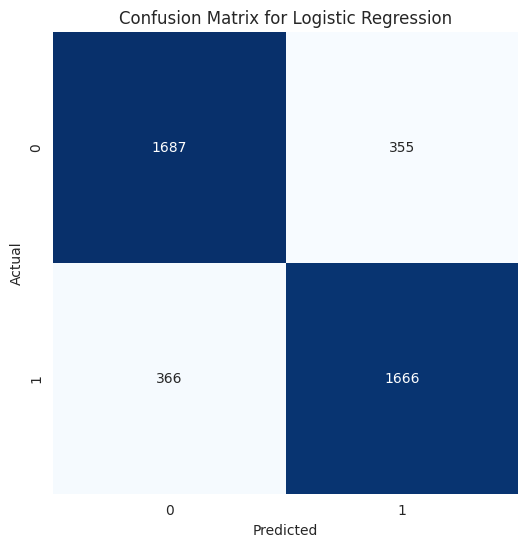

(0.8230240549828178,
 '              precision    recall  f1-score   support\n\n           0       0.82      0.83      0.82      2042\n           1       0.82      0.82      0.82      2032\n\n    accuracy                           0.82      4074\n   macro avg       0.82      0.82      0.82      4074\nweighted avg       0.82      0.82      0.82      4074\n')

In [ ]:
# Logistic Regression
logistic_model = LogisticRegression(max_iter=10000)
logistic_model.fit(X_train, y_train)
logistic_pred = logistic_model.predict(X_test)

# Evaluation
logistic_accuracy = accuracy_score(y_test, logistic_pred)
logistic_report = classification_report(y_test, logistic_pred)
logistic_cm = confusion_matrix(y_test, logistic_pred)

# Visualization
plt.figure(figsize=(6, 6))
sns.heatmap(logistic_cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

logistic_accuracy, logistic_report


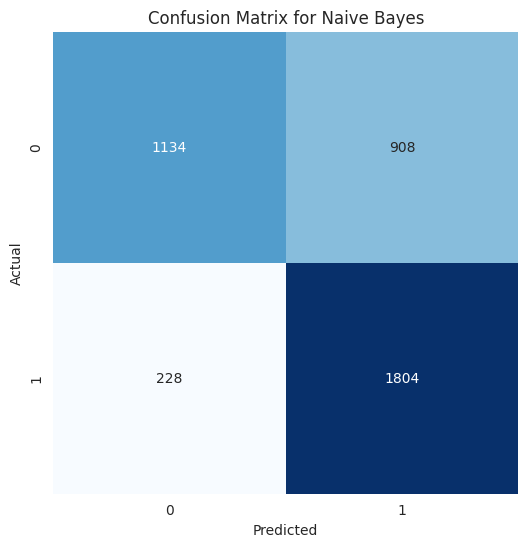

(0.7211585665193913,
 '              precision    recall  f1-score   support\n\n           0       0.83      0.56      0.67      2042\n           1       0.67      0.89      0.76      2032\n\n    accuracy                           0.72      4074\n   macro avg       0.75      0.72      0.71      4074\nweighted avg       0.75      0.72      0.71      4074\n')

In [ ]:
# Naive Bayes
naive_bayes_model = GaussianNB()
naive_bayes_model.fit(X_train, y_train)
naive_bayes_pred = naive_bayes_model.predict(X_test)

# Evaluation
naive_bayes_accuracy = accuracy_score(y_test, naive_bayes_pred)
naive_bayes_report = classification_report(y_test, naive_bayes_pred)
naive_bayes_cm = confusion_matrix(y_test, naive_bayes_pred)

# Visualization
plt.figure(figsize=(6, 6))
sns.heatmap(naive_bayes_cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Naive Bayes')
plt.show()

naive_bayes_accuracy, naive_bayes_report


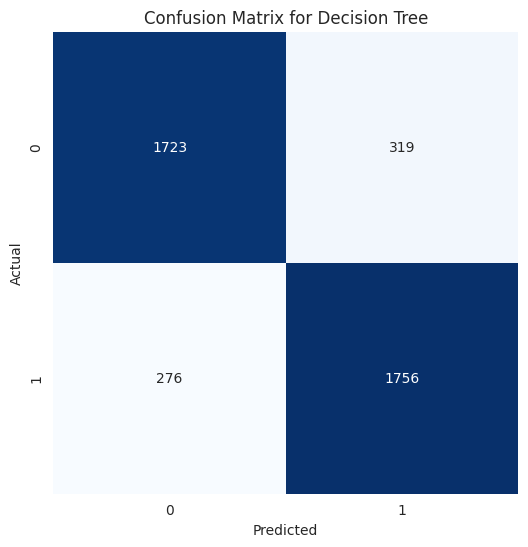

(0.8539518900343642,
 '              precision    recall  f1-score   support\n\n           0       0.86      0.84      0.85      2042\n           1       0.85      0.86      0.86      2032\n\n    accuracy                           0.85      4074\n   macro avg       0.85      0.85      0.85      4074\nweighted avg       0.85      0.85      0.85      4074\n')

In [ ]:
# Decision Tree
decision_tree_model = DecisionTreeClassifier()
decision_tree_model.fit(X_train, y_train)
decision_tree_pred = decision_tree_model.predict(X_test)

# Evaluation
decision_tree_accuracy = accuracy_score(y_test, decision_tree_pred)
decision_tree_report = classification_report(y_test, decision_tree_pred)
decision_tree_cm = confusion_matrix(y_test, decision_tree_pred)

# Visualization
plt.figure(figsize=(6, 6))
sns.heatmap(decision_tree_cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Decision Tree')
plt.show()

decision_tree_accuracy, decision_tree_report


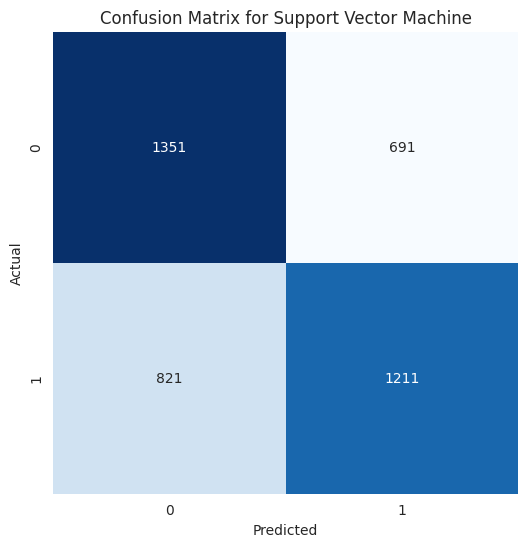

(0.6288659793814433,
 '              precision    recall  f1-score   support\n\n           0       0.62      0.66      0.64      2042\n           1       0.64      0.60      0.62      2032\n\n    accuracy                           0.63      4074\n   macro avg       0.63      0.63      0.63      4074\nweighted avg       0.63      0.63      0.63      4074\n')

In [ ]:
# Support Vector Machine (SVM)
svm_model = SVC()
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)

# Evaluation
svm_accuracy = accuracy_score(y_test, svm_pred)
svm_report = classification_report(y_test, svm_pred)
svm_cm = confusion_matrix(y_test, svm_pred)

# Visualization
plt.figure(figsize=(6, 6))
sns.heatmap(svm_cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Support Vector Machine')
plt.show()

svm_accuracy, svm_report


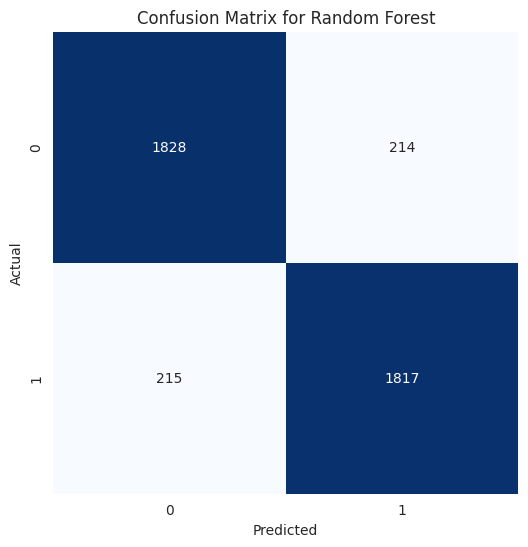

(0.894698085419735,
 '              precision    recall  f1-score   support\n\n           0       0.89      0.90      0.89      2042\n           1       0.89      0.89      0.89      2032\n\n    accuracy                           0.89      4074\n   macro avg       0.89      0.89      0.89      4074\nweighted avg       0.89      0.89      0.89      4074\n')

In [ ]:
# Random Forest
random_forest_model = RandomForestClassifier()
random_forest_model.fit(X_train, y_train)
random_forest_pred = random_forest_model.predict(X_test)

# Evaluation
random_forest_accuracy = accuracy_score(y_test, random_forest_pred)
random_forest_report = classification_report(y_test, random_forest_pred)
random_forest_cm = confusion_matrix(y_test, random_forest_pred)

# Visualization
plt.figure(figsize=(6, 6))
sns.heatmap(random_forest_cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Random Forest')
plt.show()

random_forest_accuracy, random_forest_report
